In [1]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.pipeline import Pipeline
import spacy
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix

import pandas as pd
from sklearn.model_selection import train_test_split
from proj_helper import Helper, TimeHelper
import joblib

1 - General Greeting	Used Hi for all injection words (Hey, Hi,..) <br>
2 - Greeting + Checkback	Replaced usergreetings -> Good Morning <br>
3 - Ask Available Services	Eg:- All available services <br>
4 - Ask General Services	Eg :- Hair cut, Colouring … <br> 
5 - Make Reservation	<br>
6 - Change Reservation	<br>
7 - Remove/Cancel Reservation	<br>
8 - 8 - Close Chat / Close greeting <br>

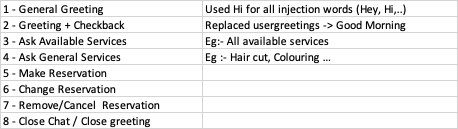


In [2]:
chat_data = pd.read_excel('UserChatData.xlsx', header=0) 

In [3]:
chat_data.head()

,Chat,Group
0,interjection,1
1,interjection I am username,1
2,interjection I'm username,1
3,interjection Glad to meet you!,1
4,interjection Nice to meet you!,1


In [4]:
chat_data['Group'].value_counts()

4    79
3    75
5    67
6    66
1    64
7    60
2    60
8    43
Name: Group, dtype: int64

In [5]:
item = Helper()
# item.preprocess("Heyy I'm Mudith")

for row in range(len(chat_data['Chat'])):
    chat_data['Chat'][row] = item.preprocess_givendata(chat_data['Chat'][row])

chat_data['Chat']

<ipython-input-5-659158dd99a6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chat_data['Chat'][row] = item.preprocess_givendata(chat_data['Chat'][row])


0                       interjection
1         interjection I am username
2         interjection I 'm username
3      interjection Glad to meet you
4      interjection Nice to meet you
                   ...              
509              thank you very much
510           very well interjection
511              Have a nice day Bye
512    Thank you for your help . Bye
513              Thanks for the info
Name: Chat, Length: 514, dtype: object

In [6]:
shuffle_df = chat_data.sample(n=len(chat_data), random_state=21)
x_train,x_test,y_train,y_test=train_test_split(shuffle_df['Chat'],shuffle_df['Group'],test_size=0.20,random_state = 21)

In [7]:
# pipe = Pipeline([('Count_Vect',CountVectorizer()),
#                  ('tfidf', TfidfTransformer()),
#                  ('MNB', MultinomialNB(alpha=0.1))])

# pipe = Pipeline([('Count_Vect',CountVectorizer()),
#                  ('tfidf', TfidfTransformer()),
#                  ('SGD', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=12, max_iter=5, tol=None))])

pipe = Pipeline([('Count_Vect',CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('LR', LogisticRegression(penalty='l1', n_jobs=1, C=1e5, solver='saga', max_iter=250, random_state=12))])

pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
y_true = y_test

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        13
           3       0.88      1.00      0.93        14
           4       0.86      0.80      0.83        15
           5       0.92      0.85      0.88        13
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        14
           8       1.00      1.00      1.00         5

    accuracy                           0.95       103
   macro avg       0.96      0.96      0.96       103
weighted avg       0.95      0.95      0.95       103



/Users/Chathuranga/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [8]:
confusion_matrix(y_true, y_pred,labels=[1, 2, 3, 4, 5, 6, 7, 8])

array([[14,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 13,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 14,  0,  0,  0,  0,  0],
       [ 0,  0,  2, 12,  1,  0,  0,  0],
       [ 0,  0,  0,  2, 11,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 15,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 14,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  5]])

In [9]:
# save the model to disk
filename = 'Group_model.sav'
joblib.dump(pipe, filename)

['Group_model.sav']

In [10]:
# load the model from disk
# loaded_model = joblib.load("Group_model.sav")

In [11]:
item.preprocess("Hi There")

'Hi There'

In [12]:
# loaded_model.predict([item.preprocess("Hi There")])
# print(x_test)

In [13]:
item.preprocess_givendata("Hi I'm Mudith. Good Morning. I need to know about hair cut and coloring. Reservation for Lalith")

Pass


"interjection i 'm username . usergreet . i need to know about hair gservice and gservice . reservation for lalith"

In [14]:
item.check_client_name("Yes it's for Lalith")

In [15]:
d = {'chat': x_test, 'actual': y_test, 'pred': y_pred}
len(y_train)
df = pd.DataFrame(data=d)
df[90:]

,chat,actual,pred
468,interjection is it possible to cancel my appoi...,7,7
205,I would like to know about gservice prices,4,4
311,interjection usergreet I need to get gservice,5,5
152,interjection usergreet . I am username . I nee...,3,3
374,ohh interjection . i would like to change my r...,6,6
425,interjection I want to remove appointment day,7,7
390,usergreet I like to change my appointment time...,6,6
79,I am username hope you are doing well,2,2
398,usergreet I like to change time for my reserva...,6,6
2,interjection I 'm username,1,1


In [16]:
pipe_data = pipe.steps[2][1]

In [17]:
coefs = np.abs(pipe_data.coef_[0])
indices = np.argsort(coefs)[::-1]
feature_set = pipe.steps[0][1].get_feature_names()

In [18]:
impordf = pd.DataFrame({'Word' : feature_set,'Importance' : coefs})
impordf = impordf.sort_values(['Importance', 'Word'], ascending=[0, 1])
impordf.head(20)

,Word,Importance
66,meet,10.139860
9,are,9.070315
32,fine,8.465201
56,interjection,7.110803
51,how,6.912230
27,day,6.324049
49,hola,6.222168
127,yo,6.189634
113,usergreet,6.030472
58,it,5.694270


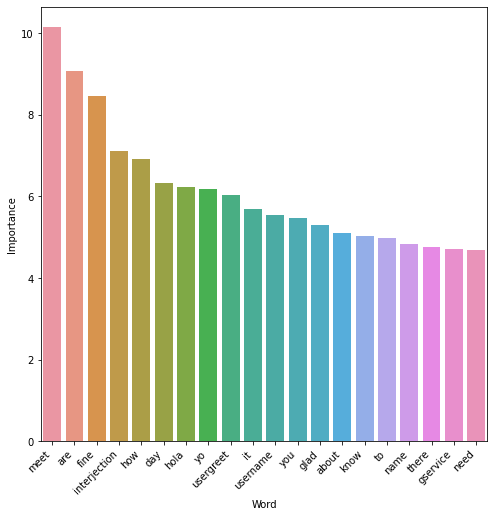

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

fig_dims = (8, 8)
fig, ax = plt.subplots(figsize=fig_dims)
# plt.ylabel('Importance')
sns.barplot(x = "Word",
            y = "Importance", 
            data=impordf.head(20))
plt.xticks(rotation=45, ha='right')
# ax.set(ylabel='Importance')
plt.show()